In [360]:
%matplotlib inline

In [361]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp

from matplotlib import pyplot as plt
from helpers import draw_edges, get_borderless_fig, pos_spring_layout, signed_layout, get_lcc, signed_normalized_laplacian, flatten

In [415]:
g = nx.read_gpickle('graphs/slashdot.pkl')
A = nx.adj_matrix(g, weight='sign')


In [416]:
df = pd.read_pickle('outputs/slashdot.pkl')

In [417]:
df['size1'] = df['C1'].apply(lambda d: d.shape[0])
df['size2'] = df['C2'].apply(lambda d: d.shape[0])

# observation 1 (to be checked further)

- some communities are not polarized communities (e.g, one side is empty)

In [418]:
df.sort_values(by='best_beta', ascending=True).head(5)

,query,C1,C2,k,best_beta,beta_array,size1,size2
22150,67674,"[67674, 76209, 76207, 76210, 76208, 67673, 368...",[],200,0.023256,"[1.0, 0.8, 0.7142857142857143, 0.6666666666666...",8,0
23012,71413,"[71413, 77220, 77221, 71412, 71410, 71411, 766...",[],200,0.037037,"[1.0, 1.0, 1.0, 0.8, 0.6, 0.23809523809523808,...",9,0
13212,75545,"[75545, 77108, 75553, 75542, 75549, 75554, 755...",[],200,0.041667,"[1.0, 0.5, 0.6666666666666666, 0.6923076923076...",17,0
32639,75552,"[75552, 75554, 75551, 75550, 75549, 75548, 755...",[],200,0.041667,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",17,0
33610,73684,"[73684, 73682, 73685, 73683, 73681, 11575]",[],200,0.052632,"[1.0, 0.6666666666666666, 0.5555555555555556, ...",6,0


(<matplotlib.figure.Figure at 0x7f7f6954b908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7f69c02ac8>)

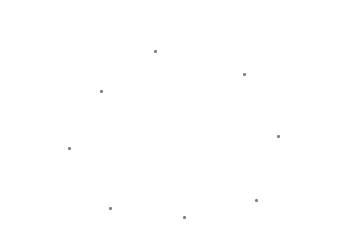

In [419]:
r = df.sort_values(by='best_beta', ascending=True).iloc[0]
draw_graph(r['C1'], use_lcc=False)

# top polarized groups

- each side has reasonable size (>10)
- and they're relatively balanced

In [421]:
df['balancedness'] = np.minimum(df['size1'], df['size2']) / (df['size1'] + df['size2'])

In [422]:
pol_df = df[(df['size1'] > 10) & (df['size2'] > 10) & (df['balancedness'] > 0.3)]

In [423]:
pol_df.sort_values(by='best_beta', ascending=True).head(5)

,query,C1,C2,k,best_beta,beta_array,size1,size2,balancedness
31765,73654,"[73654, 55935, 73655, 55936, 60591, 60585, 605...","[73653, 60596, 60595, 55929, 55926, 55931, 559...",200,0.320755,"[1.0, 0.5, 0.5, 0.5555555555555556, 0.38461538...",16,11,0.407407
40330,73805,"[73805, 59083, 59081, 59082, 73834, 73830, 738...","[56472, 69320, 25689, 25503, 25697, 25622, 178...",200,0.486705,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",70,43,0.380531
5029,73834,"[73834, 59083, 59081, 59082, 73789, 73794, 737...","[56472, 69320, 25689, 25622, 25503, 25697, 178...",200,0.486705,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",70,43,0.380531
5716,73810,"[73810, 59083, 59081, 59082, 73791, 73823, 738...","[56472, 69320, 25697, 25689, 25622, 25503, 178...",200,0.486705,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",70,43,0.380531
12437,32169,"[32169, 65055, 59804, 59806, 59805, 49008, 321...","[59802, 77258, 59803, 74812, 61679, 41446, 490...",200,0.488550,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75,...",25,11,0.305556


In [424]:
def draw_graph(C, layout='pos', show_query=False, r=None, use_lcc=True):
    assert layout in {'pos', 'spectral'}
    subg = g.subgraph(C)
    if use_lcc:
        print('use largest CC')
        subg = get_lcc(subg)
    mapping = {n: i for i, n in enumerate(subg.nodes())}
    subg = nx.relabel_nodes(subg, mapping=mapping)

    if layout == 'pos':
        pos = pos_spring_layout(subg)
    else:
        pos = signed_layout(subg)

    fig, ax = get_borderless_fig()
    # draw_nodes(subg, pos, ax=ax)
    nx.draw_networkx_nodes(subg, pos, node_size=10, linewidths=0, alpha=0.5, node_color='black')        
    if show_query:
        nx.draw_networkx_nodes(subg, pos, nodelist=[mapping[r['query']]],
                               node_size=80, linewidths=0,
                               node_color='green',
                               node_shape='s')
    draw_edges(subg, pos, ax=ax, width=1.0, alpha=0.5)
    return fig, ax

In [425]:
def show_subgraph(idx):
    r = pol_df.iloc[idx]
    C1, C2 = map(list, [r['C1'], r['C2']])
    C = C1 + C2
    fig, ax = draw_graph(C, show_query=True, r=r, use_lcc=False)
    ax.set_title('q: {}, |C1|={}, |C2|={}'.format(r['query'], r['size1'], r['size2']))
    fig.savefig('figs/slashdot/{}.pdf'.format(r['query']))    

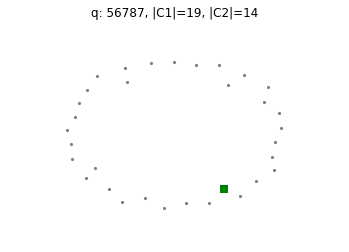

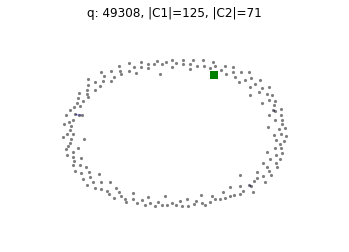

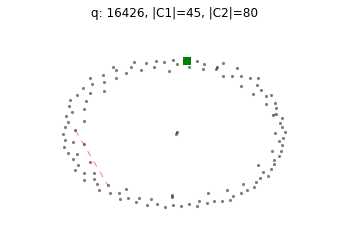

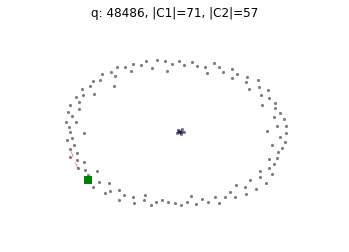

In [426]:
for i in range(1, 5):
    show_subgraph(i)

# observation 2

- some noisy nodes that are connected by negative edges 
- also nodes without any connections??

# observation on FOCG

-  only returns 3 reasonable pairs (>10 nodes together)


In [308]:
fog_data = sio.loadmat('outputs/focg-slashdot.mat')

In [311]:
fog_comms = []
for i in range(fog_data['X_enumKOCG_cell'].shape[0]):
    r = fog_data['X_enumKOCG_cell'][i][0]
    if r.nnz > 20:
        r1 = r.tocsc()
        nnz_per = [r1[:, i].nnz for i in range(r.shape[1])]
        print('community sizes', nnz_per)
        fog_comms.append(r)

community sizes [200, 1]
community sizes [200, 1]
community sizes [45, 1]


In [313]:
from helpers import pos_adj, neg_adj
def cohe(A, C):
    n = C.shape[0]
    return pos_adj(A[C, :][:, C]).sum() / (n * (n-1))
def oppo(A, C1, C2):
    n1, n2 = C1.shape[0], C2.shape[0]
    return neg_adj(A[C1, :][:, C2]).sum() / (n1 * n2)

set()
use largest CC
set()
use largest CC
set()
use largest CC


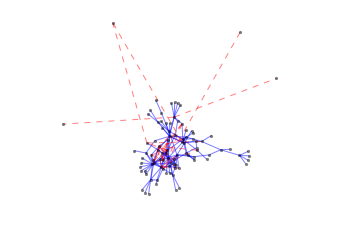

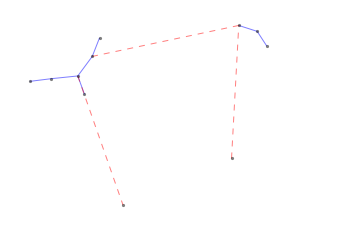

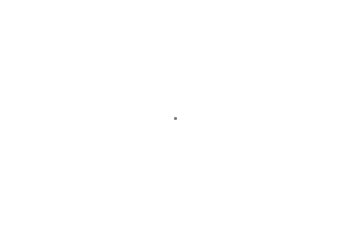

In [162]:
for i, comm in enumerate(fog_comms):
    C1 = set(comm[:, 0].nonzero()[0])
    C2 = set(comm[:, 1].nonzero()[0])
    print(C1.intersection(C2))
    fig, ax = draw_graph(C1|C2, layout='pos')
    fig.savefig('figs/slashdot/focg-{}.pdf'.format(i))

# why so many disconnected nodes?

in summary, some nodes (say 336 in this case) has high degree, and most of the degree comes from low ranking nodes, including it will increase $\beta$

the following code shows one specific example

In [179]:
print('1 community by Local')
r = pol_df.iloc[1]
C1, C2 = map(set, (r['C1'], r['C2']))
C = C1 | C2
subg = g.subgraph(C)
print(list(map(len, nx.connected_components(subg))))

1 community by Local
[12, 1, 2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [244]:
from core import query_graph, sweep_on_x_fast
from helpers import pos_nbrs, neg_nbrs, sbr

In [384]:
x, obj = query_graph(g, [[56787]], kappa=0.8, max_iter=30, verbose=1)

matrices loading done
found lambda_1= (0.017225304254288358+0j)
at iteration 5 (alpha=-31280.04581)
residual: sqrt(kappa) - y' D s=-0.10557280899690569
at iteration 10 (alpha=-977.48474)
residual: sqrt(kappa) - y' D s=-0.10557280321008966
at iteration 15 (alpha=-30.52971)
residual: sqrt(kappa) - y' D s=-0.10556722774233063
at iteration 20 (alpha=-0.93737)
residual: sqrt(kappa) - y' D s=-0.10377555670038674
at iteration 25 (alpha=-0.01261)
residual: sqrt(kappa) - y' D s=-0.09384016059822153
at iteration 30 (alpha=0.01629)
residual: sqrt(kappa) - y' D s=-0.09244043248583922


In [385]:
C1, C2, C, best_t, best_beta, ts, beta_array = sweep_on_x_fast(g, x, top_k=400)

In [386]:
def nbrs(g, n):
    return [(i, g[n][i]['sign']) for i in g.neighbors(n)]
subg = g.subgraph(C)

print('336\'s nbrs from C1, as you can see they are all + edges\n')
for n in ref['C1']:
    if 336 in list(g.neighbors(n)):
        print('nbrs({}) in g'.format(n), nbrs(g, n))

336's nbrs from C1, as you can see they are all + edges

nbrs(12520) in g [(336, 1), (22536, 1), (67639, -1)]
nbrs(12521) in g [(336, 1)]
nbrs(12518) in g [(336, 1), (4440, 1), (26285, 1), (8327, -1)]


In [387]:
print('pos/neg degree of 336: (which is not included in C1)')
print(len(pos_nbrs(g, 336)), len(neg_nbrs(g, 336)))

pos/neg degree of 336: (which is not included in C1)
181 81


In [388]:
print('if we include 336 into C1, the new beta would be:', sbr(nx.adjacency_matrix(g, weight='sign'), list(C1) + [336], C2))
print('compared to excluding 336, beta is', best_beta)

if we include 336 into C1, the new beta would be: 0.7416452442159382
compared to excluding 336, beta is 0.6893353941267388


# sweep on $v_1$

In [337]:
L = signed_normalized_laplacian(nx.adj_matrix(g, weight='sign'))
l, v = sp.linalg.eigs(L, k=1, which='SM')
v = flatten(v)
C1, C2, C, best_t, best_beta, ts, beta_array = sweep_on_x_fast(g, v)

In [395]:
print(l)

[0.0172253+0.j]


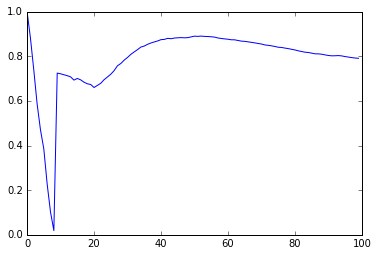

In [348]:
plt.plot(beta_array[:100])

In [347]:
C1, C2, best_t, best_beta

(array([64535, 15651, 64536, 81185, 81187, 74228, 64534, 64533, 81186]),
 array([], dtype=int64),
 0.27761139757001246,
 0.018867924528301886)

use largest CC


(<matplotlib.figure.Figure at 0x7f7f6104bba8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7f6106f908>)

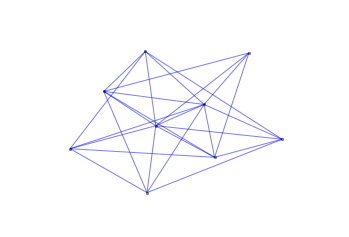

In [356]:
draw_graph(list(C1) + list(C2))